Acceso a DATOS

In [0]:
### Codigo realizado por Ing.Yilsey Teresa  Benavides Miranda en adaptación al codigo en GEE  de estimación de biomasa aerea "AGB estimated using Chave et al. and Alvarez et al. type I allometries"realizado por Dr. Pedro Rodriguez-Veiga Research Associate University of Leicester, University Road,

In [0]:
from google.colab import drive
drive.mount('/Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /Drive


In [0]:
import numpy as np
import os
from osgeo import gdal,ogr
from glob import glob
import matplotlib.pyplot as plt
import matplotlib as mpl

In [0]:
Files = glob(r'/Drive/My Drive/tile/*')
for x in Files:
    print (x)

/Drive/My Drive/tile/5. SEÑALIZACION.rar
/Drive/My Drive/tile/TEST
/Drive/My Drive/tile/TRAIN
/Drive/My Drive/tile/medianas_2010-2012.tiff
/Drive/My Drive/tile/MEDIANAS.tif
/Drive/My Drive/tile/Conglomerados.cpg
/Drive/My Drive/tile/Conglomerados.shp.xml
/Drive/My Drive/tile/Conglomerados.dbf
/Drive/My Drive/tile/Conglomerados.shx
/Drive/My Drive/tile/Conglomerados.shp
/Drive/My Drive/tile/Conglomerados.sbn
/Drive/My Drive/tile/Conglomerados.prj
/Drive/My Drive/tile/Conglomerados.sbx
/Drive/My Drive/tile/salida_9.tiff
/Drive/My Drive/tile/salida_test3.tiff


In [0]:
pImag = r'/Drive/My Drive/tile/MEDIANAS.tif'
src_ds=gdal.Open(pImag) 
gt=src_ds.GetGeoTransform()
NroBands = src_ds.RasterCount
#rb = src_ds.GetRasterBand(1)
datos = src_ds.GetRasterBand(1).ReadAsArray()

rows, cols = datos.shape
n_samples = rows*cols
NroBands

6

In [0]:
datos

array([[ 533.78296,  531.5558 ,  530.8134 , ..., 1078.4534 ,  985.89636,
         975.7706 ],
       [ 536.01013,  532.2982 ,  531.5558 , ..., 1067.6403 , 1022.9192 ,
         883.118  ],
       [ 531.5558 ,  534.5254 ,  536.01013, ...,  955.408  ,  889.82007,
         833.3881 ],
       ...,
       [ 781.25916,  834.00104,  781.3976 , ..., 1322.2383 , 1262.7244 ,
        1240.8896 ],
       [ 809.6586 ,  856.9911 ,  787.3448 , ...,  848.06116,  919.0851 ,
        1096.5305 ],
       [ 756.2406 ,  785.99243,  848.87695, ...,  955.17065,  994.70624,
         998.3848 ]], dtype=float32)

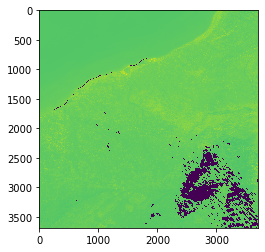

In [0]:
plt.imshow(datos)

In [0]:
shapeFileCorte = r'/Drive/My Drive/tile/Conglomerados.shp'
ds=ogr.Open(shapeFileCorte)
lyr=ds.GetLayer()
print(lyr)
pAttributo = 'K10'
pAttrAGB = 'cha_HD'
print("Nro poligonos en Shape:",lyr.GetFeatureCount())
pClasesName = []
       #lee todos los poligonos para extraer el numero de clases en el arreglo 
for feature in lyr:
    pClasesName.append(feature.GetField(pAttributo))
    pClasesName = list(dict.fromkeys(pClasesName)) # remueve Duplicados
print(pClasesName)
proj='GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]'


<osgeo.ogr.Layer; proxy of <Swig Object of type 'OGRLayerShadow *' at 0x7fcf2ba6f810> >
Nro poligonos en Shape: 9
[7.0, 1.0, 9.0, 5.0, 6.0, 2.0, 10.0]


In [0]:
def rasterizar_entrenamiento(plyr, pValFilter, pAttrFil, pAttrAGB, rows, cols , geo_transform, projection):
  labeled_pixels = np.zeros((rows, cols)) # imagen base de zeros donde empieza a llenar
  plyr.SetAttributeFilter(pAttrFil + " <> " + "'" + str(pValFilter) + "'")  #### Con este filtra
  print("Nro de Pol Filtrados  <> de",str(pValFilter),":", plyr.GetFeatureCount())
  pClasesAGB = []
  for feature in plyr:
      pClasesAGB.append(feature.GetField(pAttrAGB))
  pClasesAGB = list(dict.fromkeys(pClasesAGB)) # remueve Duplicados si hay dos o mas poligonos con el mismo AGB
  print(pClasesAGB)
  
  #driver = gdal.GetDriverByName('MEM')
  #target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
  for val in pClasesAGB:
      plyr.SetAttributeFilter(pAttrAGB + " = " + str(val))  #### Con este filtra
      print("AGB:", val , "nroPol:", plyr.GetFeatureCount())
      driver = gdal.GetDriverByName('MEM')
      target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
      target_ds.SetGeoTransform(geo_transform)
      target_ds.SetProjection(projection)
      gdal.RasterizeLayer(target_ds, [1], plyr, burn_values=[val]) ## Asigna el valor de label al poligono 
      #return target_ds
      band = target_ds.GetRasterBand(1)
      labeled_pixels += band.ReadAsArray()
  return labeled_pixels

In [0]:
pClasesName

[7.0, 1.0, 9.0, 5.0, 6.0, 2.0, 10.0]

In [0]:
ImagesTrain = []
for K in pClasesName: # Recorre los ipcc o Kfold
    pima = rasterizar_entrenamiento(lyr, K, pAttributo, pAttrAGB, rows, cols, gt, proj) #rasteriza todos menos el kfold
    print(pima.max())
    ImagesTrain.append(pima)
        ##############   con la imagen rasterizada se realiza clasificacion en esta parte del codigo para cada uno de los K-fold   ##################
    

Nro de Pol Filtrados  <> de 7.0 : 6
[12.3532, 2.28068, 10.8896, 6.44028, 6.48006, 5.95838]
AGB: 12.3532 nroPol: 1
AGB: 2.28068 nroPol: 1
AGB: 10.8896 nroPol: 1
AGB: 6.44028 nroPol: 1
AGB: 6.48006 nroPol: 1
AGB: 5.95838 nroPol: 1
12.0
Nro de Pol Filtrados  <> de 1.0 : 8
[4.34956, 13.6518, 2.28068, 10.8896, 6.44028, 6.48006, 5.95838, 4.44512]
AGB: 4.34956 nroPol: 1
AGB: 13.6518 nroPol: 1
AGB: 2.28068 nroPol: 1
AGB: 10.8896 nroPol: 1
AGB: 6.44028 nroPol: 1
AGB: 6.48006 nroPol: 1
AGB: 5.95838 nroPol: 1
AGB: 4.44512 nroPol: 1
14.0
Nro de Pol Filtrados  <> de 9.0 : 8
[4.34956, 13.6518, 12.3532, 10.8896, 6.44028, 6.48006, 5.95838, 4.44512]
AGB: 4.34956 nroPol: 1
AGB: 13.6518 nroPol: 1
AGB: 12.3532 nroPol: 1
AGB: 10.8896 nroPol: 1
AGB: 6.44028 nroPol: 1
AGB: 6.48006 nroPol: 1
AGB: 5.95838 nroPol: 1
AGB: 4.44512 nroPol: 1
14.0
Nro de Pol Filtrados  <> de 5.0 : 8
[4.34956, 13.6518, 12.3532, 2.28068, 6.44028, 6.48006, 5.95838, 4.44512]
AGB: 4.34956 nroPol: 1
AGB: 13.6518 nroPol: 1
AGB: 12.3532 nr

In [0]:
ImagesTrain[1].mean()

4.348356024943752e-05

imagen ipcc 10


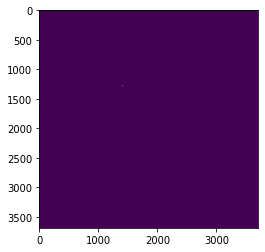

In [0]:
print("imagen ipcc 10")
plt.imshow(ImagesTrain[1]) # muestra la ultima ejecucióm

In [0]:
feature.GetField(pAttrAGB)

4.44512

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Itera las clasificaciones de los K-Fold y las guarda en un arreglo (kClasificaciones)

In [0]:
import datetime
start = datetime.datetime.now()  
print ('Comenzando Clasificacion: %s\n' % (start) )

kClasificaciones = []
# Parametros de la clasificacion
maxDepth=2
RandState=0
NroEstimator=10

for i in range(0,len(ImagesTrain)):
  print("Clasificando K-fold", i+1)
  labeled_pixels=ImagesTrain[i]
  is_train = np.nonzero(labeled_pixels)
  training_labels = labeled_pixels[is_train]
  ###
  datosBandas = src_ds.ReadAsArray()   
  ####
  print("datosBandas")
  print(datosBandas)
  bands_data = np.dstack(datosBandas)
  print("bands_data")
  print(bands_data)
  training_samples = bands_data[is_train]
  np.isfinite(training_samples)
  _msk=np.sum(np.isfinite(training_samples),1)>1
  training_samples= training_samples[_msk,:]
  training_labels=training_labels[_msk]
  #mascara valores nan por valor no data
  mask_nan=np.isnan(training_samples)
  training_samples[mask_nan]=-9999
  ##Clasificación RF por regresión 
  classifier = RandomForestRegressor(max_depth= maxDepth, random_state=RandState,   n_estimators=NroEstimator)
  classifier.fit(training_samples, training_labels)
  rows, cols, n_bands = bands_data.shape
  n_samples = rows*cols
  flat_pixels = bands_data.reshape((n_samples, n_bands))
  #mascara valores nan por valor no data
  mask_nan=np.isnan(flat_pixels)
  flat_pixels[mask_nan]=-9999
  flat_pixels = bands_data.reshape((n_samples, n_bands))
  result = classifier.predict(flat_pixels)
  classification = result.reshape((rows, cols))
  kClasificaciones.append(classification)

print ('Clasificacion RandomForest Completa --- Duracion: %s\n\n' % (datetime.datetime.now() - start))

Comenzando Clasificacion: 2019-12-29 00:28:12.919427

Clasificando K-fold 1
datosBandas
[[[ 533.78296  531.5558   530.8134  ... 1078.4534   985.89636  975.7706 ]
  [ 536.01013  532.2982   531.5558  ... 1067.6403  1022.9192   883.118  ]
  [ 531.5558   534.5254   536.01013 ...  955.408    889.82007  833.3881 ]
  ...
  [ 781.25916  834.00104  781.3976  ... 1322.2383  1262.7244  1240.8896 ]
  [ 809.6586   856.9911   787.3448  ...  848.06116  919.0851  1096.5305 ]
  [ 756.2406   785.99243  848.87695 ...  955.17065  994.70624  998.3848 ]]

 [[ 926.1334   923.45483  925.46375 ... 1854.5098  1631.2614  1612.8103 ]
  [ 926.1334   928.812    924.7941  ... 1822.9636  1710.6675  1401.1936 ]
  [ 926.1334   929.4817   928.1424  ... 1726.2717  1500.8975  1427.2612 ]
  ...
  [1625.0505  1817.9354  1638.6427  ... 1002.3351  1216.9067  2868.8208 ]
  [1779.6475  1932.6196  1699.4592  ... 1404.2554  1558.5077  2207.6394 ]
  [1529.6917  1724.358   1885.7441  ... 1714.2301  1837.0231  1896.019  ]]

 [[1540.

In [0]:
kClasificaciones[0]

array([[11.9       , 11.9       , 11.9       , ...,  6.23216513,
        10.50789474, 10.0145614 ],
       [11.9       , 11.9       , 11.9       , ...,  6.23216513,
         7.29014699, 11.1       ],
       [11.9       , 11.9       , 11.9       , ..., 10.0145614 ,
        11.5       , 11.9       ],
       ...,
       [11.9       , 11.9       , 11.9       , ...,  7.83114114,
         7.83114114,  6.23216513],
       [11.9       , 12.        , 11.9       , ..., 11.9       ,
        11.4       ,  5.81379778],
       [11.9       , 11.9       , 11.9       , ..., 11.4       ,
        10.50789474, 10.0145614 ]])

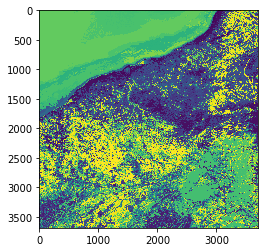

In [0]:
kClasificaciones=np.asarray(kClasificaciones)
ImgResultado = np.zeros((rows, cols))
for l in range(0,cols):
  for j in range(0,rows): 
    dato = kClasificaciones[:,j,l]
    percent=np.percentile(dato,q=[5,95])
    datoFinal = np.median(dato[np.logical_and(dato>percent[0],dato<percent[1])])
    ImgResultado[j,l] = datoFinal

plt.imshow(ImgResultado)


Imagen Clasificada Valor de AGB para el Kfold-1


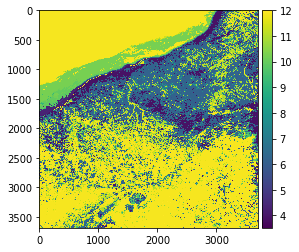

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
print("Imagen Clasificada Valor de AGB para el Kfold-1")
ax = plt.subplot(111)
im = ax.imshow(kClasificaciones[0])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax);

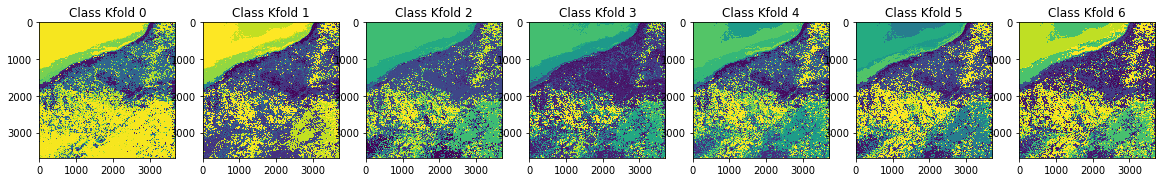

In [0]:
fig, axs = plt.subplots(1, 7, figsize=(20,10))
pCont = 0
for ax, pIma in zip(axs, kClasificaciones):
  ax.set_title('Class Kfold ' + str(pCont))
  ax.imshow(pIma)
  pCont += 1
  

## Validadion de la Clasificacion

In [0]:

def ValidarClass(plyr, pValFilter, pAttrFil, pAttrAGB, geo_transform, projection, kFoldImg):
  rows, cols = kFoldImg.shape
  labeled_pixels = np.zeros((rows, cols)) # imagen base de zeros donde empieza a llenar
  plyr.SetAttributeFilter(pAttrFil + " = " + "'" + str(pValFilter) + "'")  #### Con este filtra
  print("Nro Poligonos para el Kfold", str(pValFilter), " = ", plyr.GetFeatureCount())
  pClasesAGB = []
  for feature in plyr:
      pClasesAGB.append(feature.GetField(pAttrAGB))
  pClasesAGB = list(dict.fromkeys(pClasesAGB)) # remueve Duplicados si hay dos o mas poligonos con el mismo AGB
  for val in pClasesAGB:
      plyr.SetAttributeFilter(pAttrAGB + " = " + str(val))  #### Con este filtra
      print("AGB:", val , "nroPol:", plyr.GetFeatureCount())
      driver = gdal.GetDriverByName('MEM')
      target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
      target_ds.SetGeoTransform(geo_transform)
      target_ds.SetProjection(projection)
      gdal.RasterizeLayer(target_ds, [1], plyr, burn_values=[val]) ## Asigna el valor de label al poligono 
      #return target_ds
      band = target_ds.GetRasterBand(1)
      ### Valida el poligono contra los datos del shape
      pImgPol = np.array(band.ReadAsArray())
      pClassImaKfold = np.array(kFoldImg)
      n_samples = rows*cols
      imagRes = np.where(pImgPol.reshape((n_samples, 1)) > 0, pClassImaKfold.reshape((n_samples, 1)), 0) 
      print("AGB en Shp: ", str(val),"Media Calculada:", np.mean(imagRes[imagRes != 0]))
      labeled_pixels += imagRes.reshape((rows, cols))
  return labeled_pixels

valid = ValidarClass(lyr, K, pAttributo, pAttrAGB, gt, proj, kClasificaciones[0])
ImagesVal1 = []
k=10
pContKfold = 0
for K in pClasesName: # Recorre los ipcc o Kfold
    valid = ValidarClass(lyr, K, pAttributo, pAttrAGB, gt, proj, kClasificaciones[pContKfold]) #rasteriza todos menos el kfold
    ImagesVal1.append(valid)
    k=k+1
    pContKfold += 1
    print(k)


Nro Poligonos para el Kfold 10.0  =  1
AGB: 5.95838 nroPol: 1
AGB en Shp:  5.95838 Media Calculada: 6.419884342682408
Nro Poligonos para el Kfold 7.0  =  3
AGB: 4.34956 nroPol: 1
AGB en Shp:  4.34956 Media Calculada: 11.9
AGB: 13.6518 nroPol: 1
AGB en Shp:  13.6518 Media Calculada: 11.9
AGB: 4.44512 nroPol: 1
AGB en Shp:  4.44512 Media Calculada: 6.232165129683926
11
Nro Poligonos para el Kfold 1.0  =  1
AGB: 12.3532 nroPol: 1
AGB en Shp:  12.3532 Media Calculada: 7.88125645035301
12
Nro Poligonos para el Kfold 9.0  =  1
AGB: 2.28068 nroPol: 1
AGB en Shp:  2.28068 Media Calculada: 6.650716693890883
13
Nro Poligonos para el Kfold 5.0  =  1
AGB: 10.8896 nroPol: 1
AGB en Shp:  10.8896 Media Calculada: 6.408605889578631
14
Nro Poligonos para el Kfold 6.0  =  1
AGB: 6.44028 nroPol: 1
AGB en Shp:  6.44028 Media Calculada: 4.4683163404216275
15
Nro Poligonos para el Kfold 2.0  =  1
AGB: 6.48006 nroPol: 1
AGB en Shp:  6.48006 Media Calculada: 5.2488777258316395
16
Nro Poligonos para el Kfold 1

In [0]:
## CÁLCULO DE ERRORES 

In [0]:
ImgResultado

array([[10.66406857, 10.66406857, 10.66406857, ...,  6.01173097,
        11.38172959, 11.38172959],
       [10.66406857, 10.66406857, 10.66406857, ...,  6.01173097,
         7.7904733 , 12.40343891],
       [10.66406857, 10.66406857, 10.66406857, ..., 11.97062312,
        12.69705169, 12.69705169],
       ...,
       [ 8.56863854,  8.56863854,  7.10906567, ...,  6.58651733,
         6.58651733,  5.79226095],
       [ 8.56863854,  8.56863854,  8.56863854, ..., 12.69705169,
        10.9837604 ,  5.59802632],
       [ 5.36333512,  8.56863854,  8.56863854, ..., 10.9837604 ,
         9.50475466,  8.72013928]])